<a href="https://colab.research.google.com/github/mostafa-ja/sample/blob/master/PyTorch_Tutorial_15_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link of tutorial ](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

[Link of explaining fiest part of codes(Python_Dictionary_Comprehensio)](https://github.com/mostafa-ja/sample/blob/master/Python_Dictionary_Comprehension.ipynb)

[Link of video in youtube](https://www.youtube.com/watch?v=K0lWSB2QoIQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=15)


In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# `Load Data

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2022-08-13 00:07:03--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 65.8.178.62, 65.8.178.52, 65.8.178.34, ...
Connecting to download.pytorch.org (download.pytorch.org)|65.8.178.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  65.8MB/s    in 0.7s    

2022-08-13 00:07:04 (65.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
import zipfile
with zipfile.ZipFile('/content/hymenoptera_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
data_transform = {'train':transforms.Compose([transforms.RandomResizedCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                  'val':transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
                                            

In [5]:
data_dir = '/content/hymenoptera_data'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transform[x]) for x in ['train','val'] }

dataloader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train','val']}

data_size = {x: len(image_dataset[x]) for x in ['train','val']}

class_names = image_dataset['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
image_dataset['train'].classes

['ants', 'bees']

# Visualize a few images

In [7]:
def imshow(inp):
  inp = inp.numpy().transpose([1,2,0])
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp,0,1) # put all data inside [0,1)
  plt.imshow(inp)

In [8]:
# Get a batch of training data
images , classes = next(iter(dataloader['train'])) # torch.Size([4, 3, 224, 224])

# Make a grid from batch
out = torchvision.utils.make_grid(images)  # torch.Size([3, 228, 906])

# torchvision.utils.make_grid() returns a tensor containing grid of images. here batch_size is 4 , so it Connects four pictures together
# convert [4, 3, 224, 224]  into [3, 228, 906] means that connect 4 pictures on the third dimension

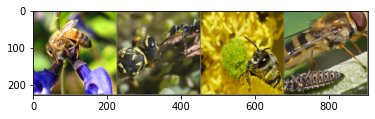

In [9]:
imshow(out)

# Training the mode

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1} ')
    print('_' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train' :
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs,labels in dataloader[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _,preds = torch.max(outputs,1)
          loss = criterion(outputs,labels)

           # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0) 
        running_corrects += torch.sum(preds == labels.data)  # labels.data ??? or labels.detach()

      if phase == 'train':
        scheduler.step()
        
      epoch_loss = running_loss / data_size[phase]
      epoch_acc = running_corrects.double() / data_size[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model




In [11]:
input

<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7f2fc0273410>>

no difference between with torch.no_grad()  & with torch.set_grad_enabled(False)


there is an additional functionality of torch.set_grad_enabled over torch.no_grad when used in a with-statement which lets you control to switch on or off gradient computation


# Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [12]:
model_ft = torchvision.models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # ResNet18_Weights.DEFAULT : best weights

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Here we use Resnet18, as our dataset is small and only has two classes. When we print the model, we see that the last layer is a fully connected layer as shown below:

(fc): Linear(in_features=512, out_features=1000, bias=True)

which we can access by *model.fc*

Thus, we must reinitialize model.fc to be a Linear layer with 512 input features and 2 output features with:

model.fc = nn.Linear(512, num_classes)

Costructur of nn.Lienar


```
def __init__(self, in_features, out_features, bias=True):
    super(Linear, self).__init__()
    self.in_features = in_features # num inputs
    self.out_features = out_features # num outputs
    self.weight = Parameter(torch.Tensor(out_features, in_features))
    if bias:
        self.bias = Parameter(torch.Tensor(out_features))
```

so, to get input_size we have to call object.in_feature and object here is fc(nn.linear)



In [13]:
print(f'the last fully conected layer : input_size={model_ft.fc.in_features} and output_size={model_ft.fc.out_features} ')

the last fully conected layer : input_size=512 and output_size=1000 


In [14]:
# an example how to get conv1 layer information
print(f'conv1 : in_channels={model_ft.conv1.in_channels}, out_channels={model_ft.conv1.out_channels}, kernel={model_ft.conv1.kernel_size}  ')

conv1 : in_channels=3, out_channels=64, kernel=(7, 7)  


In [15]:
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

In [16]:
model_ft = torchvision.models.resnet18(weights=models.ResNet18_Weights.DEFAULT) 
input_size = model_ft.fc.in_features
# redefine the fc layer
model_ft.fc = nn.Linear(input_size, 2)

model_ft = model_ft.to(device)

In [17]:
model_ft.fc

Linear(in_features=512, out_features=2, bias=True)

# StepLR

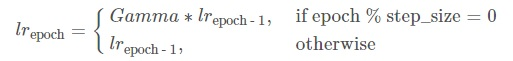

In [18]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24 
__________
train Loss: 0.5826 Acc: 0.7336
val Loss: 0.2005 Acc: 0.9216

Epoch 1/24 
__________
train Loss: 0.3826 Acc: 0.8525
val Loss: 0.2830 Acc: 0.9085

Epoch 2/24 
__________
train Loss: 0.5222 Acc: 0.7746
val Loss: 0.2472 Acc: 0.9346

Epoch 3/24 
__________
train Loss: 0.7334 Acc: 0.7090
val Loss: 0.3832 Acc: 0.8301

Epoch 4/24 
__________
train Loss: 0.9108 Acc: 0.6762
val Loss: 0.5630 Acc: 0.7908

Epoch 5/24 
__________
train Loss: 0.6174 Acc: 0.7541
val Loss: 0.5402 Acc: 0.8301

Epoch 6/24 
__________
train Loss: 0.8787 Acc: 0.7131
val Loss: 0.5228 Acc: 0.8954

Epoch 7/24 
__________
train Loss: 0.6331 Acc: 0.8197
val Loss: 0.3587 Acc: 0.8954

Epoch 8/24 
__________
train Loss: 0.6064 Acc: 0.7623
val Loss: 0.3176 Acc: 0.8889

Epoch 9/24 
__________
train Loss: 0.4206 Acc: 0.8033
val Loss: 0.2730 Acc: 0.9085

Epoch 10/24 
__________
train Loss: 0.3312 Acc: 0.8730
val Loss: 0.2378 Acc: 0.9150

Epoch 11/24 
__________
train Loss: 0.4276 Acc: 0.8197
val Loss: 0.2359 Acc